<a href="https://colab.research.google.com/github/Mrsnellek/MSDS_686_22F8W2/blob/23S8W1/MSDS%20686/Week_3/MNIST_Regularization_and_Dropout_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digits Regularization and Dropout Assignment
## Adapted from Deep Learning with Python by Francois Chollet
#### Use the MNIST digit dataset to classify digits 0 - 9 into 10 different categories.  Use regularization and early stopping to improve your neural network.

<div class="alert alert-block alert-info">
Some markdown cells might not match results as I had to rerun the notebook after writing them.
</div>

In [1]:
# Import all the necessary libraries 
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

2025-02-06 11:37:43.489388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738809463.503129   26594 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738809463.506967   26594 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 11:37:43.522255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.version.VERSION

'2.18.0'

In [3]:
tf.sysconfig.get_build_info()

OrderedDict([('cpu_compiler', '/usr/lib/llvm-18/bin/clang'),
             ('cuda_compute_capabilities',
              ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90']),
             ('cuda_version', '12.5.1'),
             ('cudnn_version', '9'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', False)])

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
keras.mixed_precision.set_global_policy('mixed_float16')

In [8]:
# Import the MNIST data set from the Keras library. https://keras.io/datasets/
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

I'll be using the fashion mnist dataset instead for this assignment.

In [9]:
# Reshape and normalize the images for your neural net

I'm gonna just add a scale and flatten layer to the model

In [10]:
# Convert the labels into categorical values.

I'd rather not. I'll use sparse categorical crossentropy loss.

In [ ]:
# Split the data into training and validation

BATCH_SIZE = 128
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE).prefetch(1)
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000, reshuffle_each_iteration=False)
val_ds = train_ds.skip(train_ds.cardinality().numpy() * .8).batch(BATCH_SIZE).prefetch(1)
train_ds = train_ds.take(train_ds.cardinality().numpy() * .8).shuffle(10000).batch(BATCH_SIZE).prefetch(1)
train_ds.cardinality().numpy() * BATCH_SIZE, val_ds.cardinality().numpy() * BATCH_SIZE, test_ds.cardinality().numpy() * BATCH_SIZE

I0000 00:00:1738808519.890245   24033 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738808519.891953   24033 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738808519.893283   24033 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738808519.994453   24033 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

(48000, 12000, 10016)

## In each Jupyter Notebook cell build a model using your test and validation data, show loss and accuracy monitoring graphs, and evaluate your model on the test data *all in one cell*.  

## Build at least 7 different models. Use markdown above the code cell to explain what you are changing/testing in the subsequent model. 

## Build models with different learning rates, batch sizes, dropout, regularization, and hidden layers and nodes.  Be strategic in how you go about optimizing your model. The last model of your notebook should be your best model. 


I'm not going to evaluate each model on the test data, because that would mean overfitting the hyperparameters to the test data which will make the accuracy not generalize to new data. That's what the validation set is for, so that each model doesn't have be measured using the test set.

I'll use the best model I found using the mnist dataset as a starting point.

# Model 1

In [12]:
model1 = keras.Sequential()
model1.add(keras.layers.Input(shape=(28, 28)))
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Rescaling(1./255))
model1.add(keras.layers.Dense(512, activation='relu'))
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.Dense(512, activation='relu'))
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.Dense(512, activation='relu'))
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.Dense(10))
model1.add(keras.layers.Softmax(dtype='float32'))

model1.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
hist = model1.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(
        'val_accuracy', 
        patience=5,
        restore_best_weights=True
    )]
)

# plot the training and validation accuracy on one graph and training and validation loss on another graph
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([])
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Print the best validation accuracy and its corresponding epoch
print('Best validation accuracy:', max(hist.history['val_accuracy']), 'at epoch', np.argmax(hist.history['val_accuracy']) + 1)

Epoch 1/100


I0000 00:00:1738808538.127867   24126 service.cc:146] XLA service 0x6ffcb4005240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738808538.127890   24126 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-02-06 11:22:18.146995: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-06 11:22:18.308850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 139/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5268 - loss: 1.3117

I0000 00:00:1738808540.715110   24126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7298 - loss: 0.7409

2025-02-06 11:22:23.154909: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 28 bytes spill stores, 28 bytes spill loads

2025-02-06 11:22:23.602608: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_50', 12 bytes spill stores, 12 bytes spill loads



1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7302 - loss: 0.7399 - val_accuracy: 0.8320 - val_loss: 0.4855
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8324 - loss: 0.4648 - val_accuracy: 0.8602 - val_loss: 0.3920
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8490 - loss: 0.4208 - val_accuracy: 0.8710 - val_loss: 0.3733
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8553 - loss: 0.4034 - val_accuracy: 0.8719 - val_loss: 0.3636
Epoch 5/100
 248/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8575 - loss: 0.3950

KeyboardInterrupt: 

I'm going to try the swish activation and add he normal kernel initialization.

# Model 2

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7280 - loss: 0.7460 - val_accuracy: 0.8518 - val_loss: 0.4030
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8463 - loss: 0.4204 - val_accuracy: 0.8708 - val_loss: 0.3600
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8586 - loss: 0.3815 - val_accuracy: 0.8641 - val_loss: 0.3623
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8655 - loss: 0.3596 - val_accuracy: 0.8773 - val_loss: 0.3282
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8729 - loss: 0.3374 - val_accuracy: 0.8858 - val_loss: 0.3161
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8785 - loss: 0.3232 - val_accuracy: 0.8802 - val_loss: 0.3265
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8833 - loss: 0.3081 - val_accuracy: 0.8823 - val_loss: 0.3374
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8870 - loss: 0.2987 - val_accu

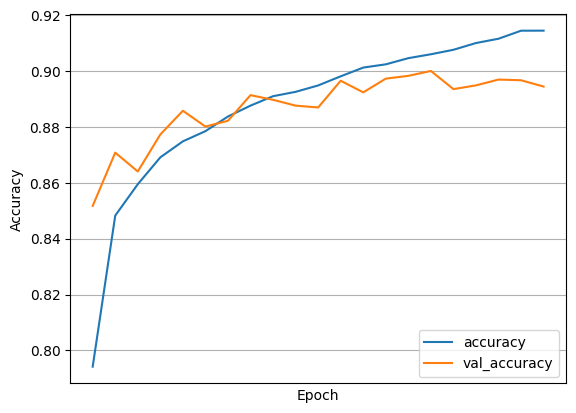

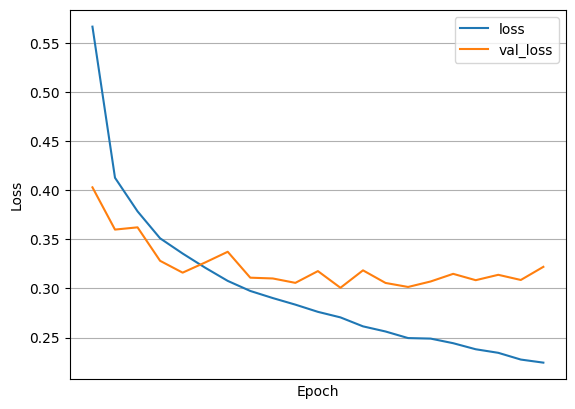

Best validation accuracy: 0.9000833630561829 at epoch 16


In [22]:
model2 = keras.Sequential()
model2.add(keras.layers.Input(shape=(28, 28)))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Rescaling(1./255))
model2.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model2.add(keras.layers.Dropout(0.3))
model2.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model2.add(keras.layers.Dropout(0.3))
model2.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model2.add(keras.layers.Dropout(0.3))
model2.add(keras.layers.Dense(10))
model2.add(keras.layers.Softmax(dtype='float32'))

model2.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
hist = model2.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(
        'val_accuracy', 
        patience=5,
        restore_best_weights=True
    )]
)

# plot the training and validation accuracy on one graph and training and validation loss on another graph
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([])
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Print the best validation accuracy and its corresponding epoch
print('Best validation accuracy:', max(hist.history['val_accuracy']), 'at epoch', np.argmax(hist.history['val_accuracy']) + 1)

That's not much different than the last model. What will happen if I add another layer and use Nadam optimizer?

# Model 3

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7249 - loss: 0.7653 - val_accuracy: 0.8501 - val_loss: 0.4084
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8440 - loss: 0.4290 - val_accuracy: 0.8645 - val_loss: 0.3691
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8566 - loss: 0.3862 - val_accuracy: 0.8577 - val_loss: 0.3701
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8690 - loss: 0.3549 - val_accuracy: 0.8726 - val_loss: 0.3355
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8729 - loss: 0.3414 - val_accuracy: 0.8831 - val_loss: 0.3261
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8784 - loss: 0.3260 - val_accuracy: 0.8835 - val_loss: 0.3254
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8801 - loss: 0.3201 - val_accuracy: 0.8717 - val_loss: 0.3426
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8886 - loss: 0.2999 - val_accu

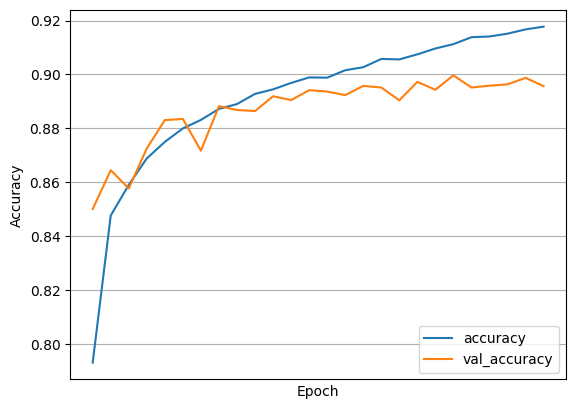

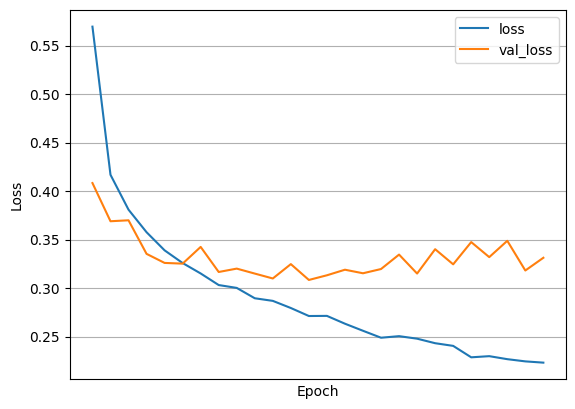

Best validation accuracy: 0.8996666669845581 at epoch 21


In [23]:
model3 = keras.Sequential()
model3.add(keras.layers.Input(shape=(28, 28)))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Rescaling(1./255))
model3.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model3.add(keras.layers.Dropout(0.3))
model3.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model3.add(keras.layers.Dropout(0.3))
model3.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model3.add(keras.layers.Dropout(0.3))
model3.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model3.add(keras.layers.Dropout(0.3))
model3.add(keras.layers.Dense(10))
model3.add(keras.layers.Softmax(dtype='float32'))

model3.compile(
    optimizer='nadam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
hist = model3.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(
        'val_accuracy', 
        patience=5,
        restore_best_weights=True
    )]
)

# plot the training and validation accuracy on one graph and training and validation loss on another graph
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([])
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Print the best validation accuracy and its corresponding epoch
print('Best validation accuracy:', max(hist.history['val_accuracy']), 'at epoch', np.argmax(hist.history['val_accuracy']) + 1)

That's worse. I'm going to try the same architechture with adam.

# Model 4

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7242 - loss: 0.7657 - val_accuracy: 0.8514 - val_loss: 0.4082
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8397 - loss: 0.4359 - val_accuracy: 0.8564 - val_loss: 0.3903
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8545 - loss: 0.3970 - val_accuracy: 0.8590 - val_loss: 0.3833
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8642 - loss: 0.3724 - val_accuracy: 0.8698 - val_loss: 0.3515
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8712 - loss: 0.3532 - val_accuracy: 0.8795 - val_loss: 0.3353
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8771 - loss: 0.3376 - val_accuracy: 0.8806 - val_loss: 0.3355
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8792 - loss: 0.3239 - val_accuracy: 0.8827 - val_loss: 0.3294
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8842 - loss: 0.3109 - val_accu

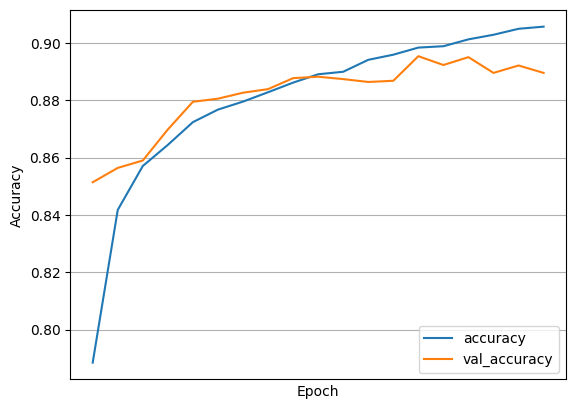

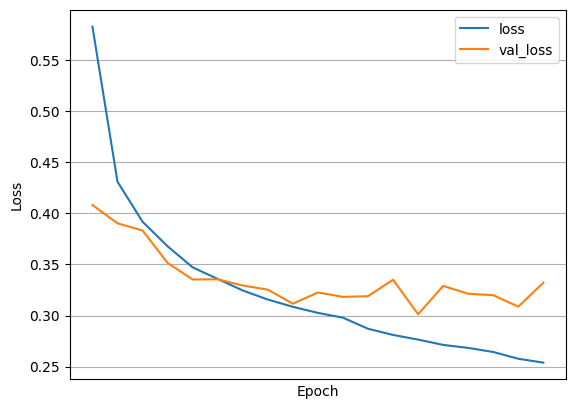

Best validation accuracy: 0.8954166769981384 at epoch 14


In [24]:
model4 = keras.Sequential()
model4.add(keras.layers.Input(shape=(28, 28)))
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Rescaling(1./255))
model4.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model4.add(keras.layers.Dropout(0.3))
model4.add(keras.layers.Dense(10))
model4.add(keras.layers.Softmax(dtype='float32'))

model4.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
hist = model4.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(
        'val_accuracy', 
        patience=5,
        restore_best_weights=True
    )]
)

# plot the training and validation accuracy on one graph and training and validation loss on another graph
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([])
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Print the best validation accuracy and its corresponding epoch
print('Best validation accuracy:', max(hist.history['val_accuracy']), 'at epoch', np.argmax(hist.history['val_accuracy']) + 1)

The second model is still the best. How about AdamW?

# Model 5

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7222 - loss: 0.7702 - val_accuracy: 0.8230 - val_loss: 0.4659
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8380 - loss: 0.4408 - val_accuracy: 0.8621 - val_loss: 0.3820
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8563 - loss: 0.3892 - val_accuracy: 0.8618 - val_loss: 0.3696
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8624 - loss: 0.3700 - val_accuracy: 0.8712 - val_loss: 0.3536
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8706 - loss: 0.3506 - val_accuracy: 0.8683 - val_loss: 0.3664
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8728 - loss: 0.3435 - val_accuracy: 0.8837 - val_loss: 0.3347
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8794 - loss: 0.3260 - val_accuracy: 0.8853 - val_loss: 0.3159
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8844 - loss: 0.3099 - val_accu

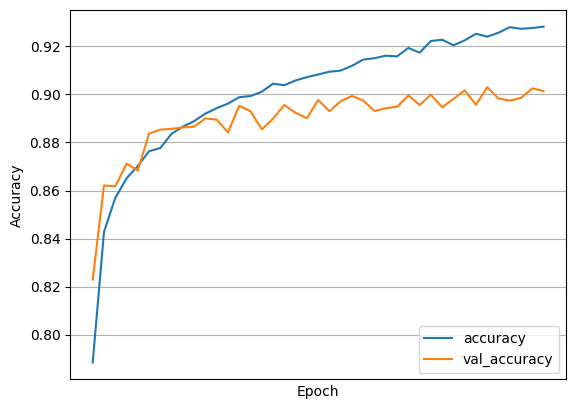

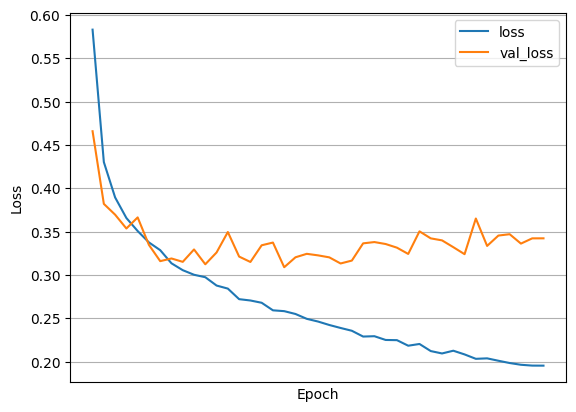

Best validation accuracy: 0.902999997138977 at epoch 36


In [25]:
model5 = keras.Sequential()
model5.add(keras.layers.Input(shape=(28, 28)))
model5.add(keras.layers.Flatten())
model5.add(keras.layers.Rescaling(1./255))
model5.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model5.add(keras.layers.Dropout(0.3))
model5.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model5.add(keras.layers.Dropout(0.3))
model5.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model5.add(keras.layers.Dropout(0.3))
model5.add(keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal'))
model5.add(keras.layers.Dropout(0.3))
model5.add(keras.layers.Dense(10))
model5.add(keras.layers.Softmax(dtype='float32'))

model5.compile(
    optimizer='adamw', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
hist = model5.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(
        'val_accuracy', 
        patience=5,
        restore_best_weights=True
    )]
)

# plot the training and validation accuracy on one graph and training and validation loss on another graph
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([])
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Print the best validation accuracy and its corresponding epoch
print('Best validation accuracy:', max(hist.history['val_accuracy']), 'at epoch', np.argmax(hist.history['val_accuracy']) + 1)

Second model is still the best. Back to adam and relu. I'll now add batch normalization.

# Model 6

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7121 - loss: 0.8043 - val_accuracy: 0.8467 - val_loss: 0.4235
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8401 - loss: 0.4381 - val_accuracy: 0.8660 - val_loss: 0.3785
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8579 - loss: 0.3832 - val_accuracy: 0.8687 - val_loss: 0.3606
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8684 - loss: 0.3575 - val_accuracy: 0.8757 - val_loss: 0.3338
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8721 - loss: 0.3423 - val_accuracy: 0.8813 - val_loss: 0.3230
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8801 - loss: 0.3275 - val_accuracy: 0.8831 - val_loss: 0.3221
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8850 - loss: 0.3131 - val_accuracy: 0.8774 - val_loss: 0.3316
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8888 - loss: 0.2946 - val_accu

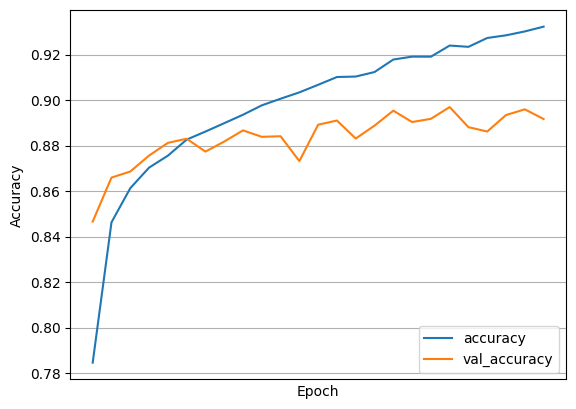

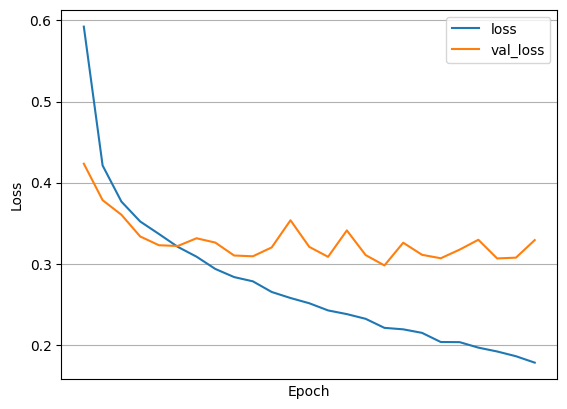

Best validation accuracy: 0.8970000147819519 at epoch 20


In [26]:
model6 = keras.Sequential()
model6.add(keras.layers.Input(shape=(28, 28)))
model6.add(keras.layers.Flatten())
model6.add(keras.layers.Rescaling(1./255))

model6.add(keras.layers.Dense(512, kernel_initializer='he_normal', use_bias=False))
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Activation('relu'))
model6.add(keras.layers.Dropout(0.3))

model6.add(keras.layers.Dense(512, kernel_initializer='he_normal', use_bias=False))
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Activation('relu'))
model6.add(keras.layers.Dropout(0.3))

model6.add(keras.layers.Dense(512, kernel_initializer='he_normal', use_bias=False))
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Activation('relu'))
model6.add(keras.layers.Dropout(0.3))

model6.add(keras.layers.Dense(512, kernel_initializer='he_normal', use_bias=False))
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Activation('relu'))
model6.add(keras.layers.Dropout(0.3))

model6.add(keras.layers.Dense(10))
model6.add(keras.layers.Softmax(dtype='float32'))

model6.compile(
    optimizer='adamw', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
hist = model6.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(
        'val_accuracy', 
        patience=5,
        restore_best_weights=True
    )]
)

# plot the training and validation accuracy on one graph and training and validation loss on another graph
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([])
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Print the best validation accuracy and its corresponding epoch
print('Best validation accuracy:', max(hist.history['val_accuracy']), 'at epoch', np.argmax(hist.history['val_accuracy']) + 1)

Well, that didn't work. Maybe without the dropout?

# Model 7

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8061 - loss: 0.5440 - val_accuracy: 0.8607 - val_loss: 0.3811
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8770 - loss: 0.3378 - val_accuracy: 0.8668 - val_loss: 0.3783
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8933 - loss: 0.2853 - val_accuracy: 0.8711 - val_loss: 0.3601
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9015 - loss: 0.2590 - val_accuracy: 0.8658 - val_loss: 0.3747
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9118 - loss: 0.2323 - val_accuracy: 0.8705 - val_loss: 0.3641
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9200 - loss: 0.2141 - val_accuracy: 0.8647 - val_loss: 0.3555
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9233 - loss: 0.1996 - val_accuracy: 0.8673 - val_loss: 0.3712
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9313 - loss: 0.1784 - val_accu

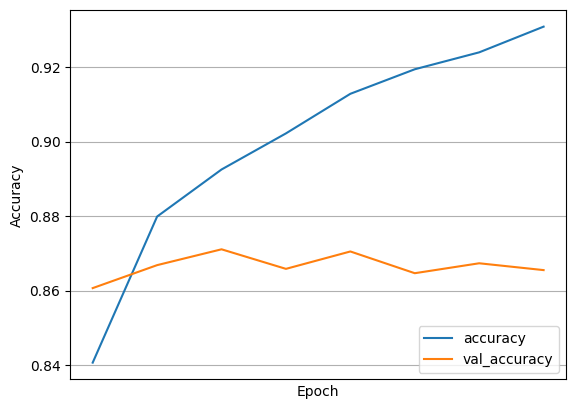

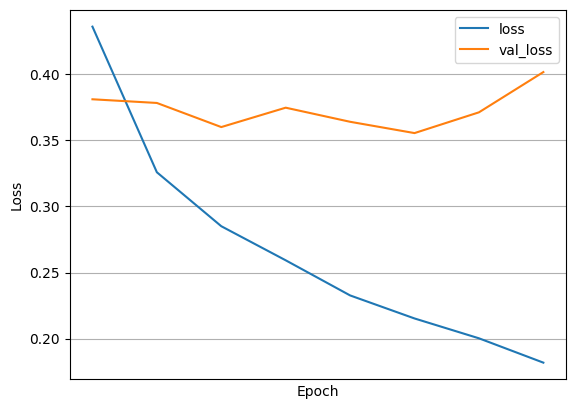

Best validation accuracy: 0.8710833191871643 at epoch 3


In [27]:
model7 = keras.Sequential()
model7.add(keras.layers.Input(shape=(28, 28)))
model7.add(keras.layers.Flatten())
model7.add(keras.layers.Rescaling(1./255))

model7.add(keras.layers.Dense(512, kernel_initializer='he_normal', use_bias=False))
model7.add(keras.layers.BatchNormalization())
model7.add(keras.layers.Activation('relu'))

model7.add(keras.layers.Dense(512, kernel_initializer='he_normal', use_bias=False))
model7.add(keras.layers.BatchNormalization())
model7.add(keras.layers.Activation('relu'))

model7.add(keras.layers.Dense(512, kernel_initializer='he_normal', use_bias=False))
model7.add(keras.layers.BatchNormalization())
model7.add(keras.layers.Activation('relu'))

model7.add(keras.layers.Dense(512, kernel_initializer='he_normal', use_bias=False))
model7.add(keras.layers.BatchNormalization())
model7.add(keras.layers.Activation('relu'))

model7.add(keras.layers.Dense(10))
model7.add(keras.layers.Softmax(dtype='float32'))

model7.compile(
    optimizer='adamw', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
hist = model7.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(
        'val_accuracy', 
        patience=5,
        restore_best_weights=True
    )]
)

# plot the training and validation accuracy on one graph and training and validation loss on another graph
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([])
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Print the best validation accuracy and its corresponding epoch
print('Best validation accuracy:', max(hist.history['val_accuracy']), 'at epoch', np.argmax(hist.history['val_accuracy']) + 1)

I still haven't been able to improve on the second model. From here I'm going to use keras tuner to find the best hyperparameters.

# Keras Tuner

In [30]:
def model_builder(hp):
    n_hidden = hp.Int('n_hidden', min_value=2, max_value=6, step=2)
    n_units = hp.Int('n_units', min_value=64, max_value=512, step=2, sampling='log')
    activation = hp.Choice('activation', values=['relu', 'swish'])
    learning_rate = hp.Float('learning_rate', min_value=1e-3, max_value=1e-2, step=10,sampling='log')
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.6, step=0.2)
    batch_norm = hp.Boolean('batch_norm')
    optimizer = hp.Choice('optimizer', values=['adam', 'nadam', 'adamw'])
    optimizer = keras.optimizers.get(optimizer)
    optimizer.learning_rate = learning_rate
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(shape=(28, 28)))
    model.add(keras.layers.Flatten())
    for _ in range(n_hidden):
        if batch_norm:
            model.add(keras.layers.Dense(int(n_units), use_bias=False, kernel_initializer='he_normal'))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Activation(activation))
            model.add(keras.layers.Dropout(dropout))
        else:
            model.add(keras.layers.Dense(int(n_units), activation=activation, kernel_initializer='he_normal'))
            model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.Softmax(dtype='float32'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

<div class="alert alert-block alert-warning">
<b>Warning:</b> Running the next cell will create a folder in your working directory and save results of the hyperparameter search
</div>

In [31]:
tuner = kt.BayesianOptimization(model_builder, objective='val_accuracy', seed=8675309, overwrite=True, project_name='fashion_mnist', max_trials=50)
tuner.search(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Trial 50 Complete [00h 00m 25s]
val_accuracy: 0.8850833177566528

Best val_accuracy So Far: 0.8956666588783264
Total elapsed time: 00h 20m 33s


In [32]:
best_trial = tuner.oracle.get_best_trials()[0]
best_trial.summary()

Trial 20 summary
Hyperparameters:
n_hidden: 4
n_units: 256
activation: relu
learning_rate: 0.001
dropout: 0.2
batch_norm: True
optimizer: nadam
Score: 0.8956666588783264


In [33]:
best_model = tuner.get_best_models()[0]
optimizer = best_trial.hyperparameters.get('optimizer')
optimizer = keras.optimizers.get(optimizer)
optimizer.learning_rate = best_trial.hyperparameters.get('learning_rate') * .1
best_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100


/home/chandon/miniconda3/envs/tf-test/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9299 - loss: 0.1901 - val_accuracy: 0.9061 - val_loss: 0.2783
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9351 - loss: 0.1732 - val_accuracy: 0.9059 - val_loss: 0.2819
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9368 - loss: 0.1650 - val_accuracy: 0.9082 - val_loss: 0.2791
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9378 - loss: 0.1642 - val_accuracy: 0.9068 - val_loss: 0.2848
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9405 - loss: 0.1582 - val_accuracy: 0.9072 - val_loss: 0.2822
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9416 - loss: 0.1553 - val_accuracy: 0.9069 - val_loss: 0.2860
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9418 - loss: 0.1553 - val_accuracy: 0.9080 - val_loss: 0.2834
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9420 - loss: 0.1545 - val_accuracy: 0.9082

In [34]:
optimizer.learning_rate = best_trial.hyperparameters.get('learning_rate') * .01
best_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9403 - loss: 0.1593 - val_accuracy: 0.9083 - val_loss: 0.2783
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9399 - loss: 0.1594 - val_accuracy: 0.9088 - val_loss: 0.2787
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9397 - loss: 0.1614 - val_accuracy: 0.9092 - val_loss: 0.2792
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9397 - loss: 0.1610 - val_accuracy: 0.9093 - val_loss: 0.2794
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9412 - loss: 0.1603 - val_accuracy: 0.9091 - val_loss: 0.2794
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9415 - loss: 0.1545 - val_accuracy: 0.9095 - val_loss: 0.2794
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9416 - loss: 0.1576 - val_accuracy: 0.9094 - val_loss: 0.2803
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9383 - loss: 0.1601 - val_accu

In [35]:
_, accuracy = best_model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

 1/79 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8984 - loss: 0.3152

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8989 - loss: 0.3158
Test accuracy: 89.94%


In [36]:
_, accuracy = model5.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

53/79 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.8951 - loss: 0.3742

2025-01-31 09:24:37.006673: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 184 bytes spill stores, 196 bytes spill loads

2025-01-31 09:24:37.072444: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 12 bytes spill stores, 12 bytes spill loads

2025-01-31 09:24:37.237070: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 104 bytes spill stores, 108 bytes spill loads



79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8953 - loss: 0.3735
Test accuracy: 89.68%


### Comment on which techniques/methods you used to build the best model with the highest accuracy.  

I tried different activations, different optimizers, and batch normalization. In the end it was hard to get much improvement past what my best model on MNIST did. The keras tuner took a long time, but I let it run in the background while I researched some things. The tuner found that swish activation, with batch normalization, and adam did the best, at least with that architechture.